In [73]:
%pylab inline
import os,sys,re
import pickle
from builtins import sum as bsum

from importlib import reload
from collections import defaultdict, namedtuple
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
flush = lambda *args, **kwargs: [sys.stdout.flush(), print(*args, **kwargs)]

Populating the interactive namespace from numpy and matplotlib


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['yticks', 'xticks']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [74]:
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])

In [75]:
# Don't reload this, otherwise it will create a new units registry object
# and will then complain about combining different registries.

# Check if units have been loaded
try:
    UNITS
except NameError:
    import units; reload(units); UNITS = units.UNITS;

In [76]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Re100_0_5mm_50Hz_streamwiseSourceSep.h5         : ['Odor Data/c1a', 'Odor Data/c2a', 'Odor Data/c3a', 'Odor Data/c4a', 'Odor Data/c5a', 'Odor Data/c6a', 'Odor Data/c7a', 'Odor Data/c8a', 'Odor Data/c9a', 'Odor Data/c10a', 'Odor Data/c11a', 'Odor Data/c12a', 'Odor Data/c13a', 'Odor Data/c14a', 'Odor Data/c15a', 'Odor Data/c16a'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow_45deg                                  : X0.418Y0.458 - X0.502Y0.542 (16 datasets)


INFO:crick:n16Tslow_X                                      : X0.400 - X0.648 (32 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


# Specify the analysis window

In [77]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[2]
fit_k         = False
fit_b         = True

SAVEPLOTS = True # Whether to actually make the plots
fig_dir_full        = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = fit_k, fit_b=fit_b, create = True); print(f"{fig_dir_full=}")
fig_dir_wnd_shp_len = fpft.get_fig_dir(window_shape = window_shape, window_length = window_length, fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_wnd_shp_len=}")
fig_dir_wnd_shp     = fpft.get_fig_dir(window_shape = window_shape, window_length = None,          fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_wnd_shp=}")
fig_dir_top         = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = None,  fit_b=None,  create = True); print(f"{fig_dir_top=}")
fig_dir_fitkb       = fpft.get_fig_dir(window_shape = None,         window_length = None,          fit_k = fit_k, fit_b=fit_b, create = True); print(f"{fig_dir_fitkb=}")

fig_dir_full='figs/kaiser9/1s/fit_k=False/fit_b=True'
fig_dir_wnd_shp_len='figs/kaiser9/1s'
fig_dir_wnd_shp='figs/kaiser9'
fig_dir_top='figs'
fig_dir_fitkb='figs/fit_k=False/fit_b=True'


# Figure showing an example plume and correlations

In [96]:
to_use = {
    "16Ts":  {"sim_name":"n16Tslow"},
    "16Ts_X":{"sim_name":"n16Tslow_X"},
    #"16Ts_45": {"sim_name":"n16Tslow_45deg"},
}
to_use = {"bw_X": {"sim_name":"boulder16streamwise"}}
for pw, k in zip("pw",[4]):
    for r in range(4):
        to_use[f"s={pw}_{r}"] = {"sim_name":"surr_all_equal", "surrogate_k":k, "random_seed":r}
        pass
         


In [97]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

su_ds = [k for k,v in to_use.items() if v["sim_name"].startswith("surr")]
surrQ = lambda x: x in su_ds
surr_trialsQ = lambda x: any([x.startswith(s) for s in ["s=p_", "s=w_"]])
#su_ds = []
print(f"Surrogate datasets = {su_ds}.")

which_srcs   = dict_update_from_field({"bw":[-3750, 3750],
                                       #"bw_X":[-3750, 3750],
                                       "bw_X":[-48750, 48750],
                                       "cr":[490000,510000],
                                       "w1":[107300, 114700], "w2":[218300,225700], "w3":[329300,336700],"w4":[440300,447700],
                                       "12T":[498000,502000], "12Ts":[498000,502000],
                                       "16T":[496000,504000], "16Ts":[496000,504000],
                                       "16Ts_X":[16000,104000],
                                       #"16Ts_45":[list(data["16Ts_45"].sims.keys())[i] for i in [4,-4]],
},       
                                      su_ds, "bw")        
t_wnd        = dict_update_from_field({"bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}, su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw")
which_idists = dict_update_from_field({"bw":[0,2,3],              "cr":[0,10,20]},             su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw")
tticks       = dict_update_from_field({"bw":DEFAULT,              "cr":[39.5,40,40.5]},        su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw")
xticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw")
yticks       = dict_update_from_field({"bw":DEFAULT,              "cr":DEFAULT},               su_ds + ["w1","w2","w3","w4","12T","12Ts","16T","16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw")
snapshot_time = defaultdict(lambda: 40000*UNITS.ms, {"12T":10001*UNITS.ms, "12Ts":40010*UNITS.ms,"16T":10001*UNITS.ms, "16Ts":40010*UNITS.ms, "16Ts_X":40010*UNITS.ms, "16Ts_45":40010*UNITS.ms})

Surrogate datasets = ['s=p_0', 's=p_1', 's=p_2', 's=p_3'].


In [98]:
safe_load = lambda d: d[0] if d is not None else d
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];
loaded = {k:safe_load(proc.load_data(init_filter = v,
                                       compute_filter = {
                                           "window_shape":window_shape,
                                           "window_length":window_length,
                                           "fit_k":fit_k,
                                           "fit_b":fit_b,
                                       },
                                     # fit_corrs = ["search.1"],
                                     fit_corrs = [],                                     
                                     ))
          for k,v in to_use.items()}

data =  {k:FisherPlumes(d) for k,d in loaded.items() if d is not None}


                    proc 2024/05/02 21:13:42     INFO: Loading init_filter={'sim_name': 'boulder16streamwise'} compute_filter={'window_shape': ('kaiser', 9), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/bw_streamwise.1/7d503c698604abaa.p, last modified 2024-05-02 21:08:03.


                    proc 2024/05/02 21:13:43     INFO: Returning 1 results.


                    proc 2024/05/02 21:13:43     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 0} compute_filter={'window_shape': ('kaiser', 9), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.00/38fba543a2b74bcb.p, last modified 2023-11-08 15:31:16.


                    proc 2024/05/02 21:13:43     INFO: Returning 1 results.


                    proc 2024/05/02 21:13:43     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 1} compute_filter={'window_shape': ('kaiser', 9), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.01/2be2b225a4e46332.p, last modified 2023-11-08 15:31:20.


                    proc 2024/05/02 21:13:44     INFO: Returning 1 results.


                    proc 2024/05/02 21:13:44     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 2} compute_filter={'window_shape': ('kaiser', 9), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.02/60d2b8475e03633d.p, last modified 2023-11-08 15:31:09.


                    proc 2024/05/02 21:13:44     INFO: Returning 1 results.


                    proc 2024/05/02 21:13:44     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'random_seed': 3} compute_filter={'window_shape': ('kaiser', 9), 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.03/fc7fc195b60fa439.p, last modified 2023-11-08 15:30:49.


                    proc 2024/05/02 21:13:45     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 0, 'surrogate_k': 4}, 'seed': 0, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 1, 'surrogate_k': 4}, 'seed': 1, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 2, 'surrogate_k': 4}, 'seed': 2, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3,

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'random_seed': 3, 'surrogate_k': 4}, 'seed': 3, 

In [99]:
snapshots_dir =defaultdict(lambda: None, {"bw": os.path.join(boulder.data_root, "original", "saved-snapshots"),
                                          "bw_X": os.path.join(boulder.data_root, "streamwise", "saved-snapshots")})

Using pair 2 for idist 0, dist 7500
ia = 3750, ib = -3750
Using pair 7 for idist 2, dist 22500
ia = 11250, ib = -11250
Using pair 8 for idist 3, dist 30000
ia = 11250, ib = -18750


Wrote figs/kaiser9/1s/plumes_demo_bw_X.pdf.


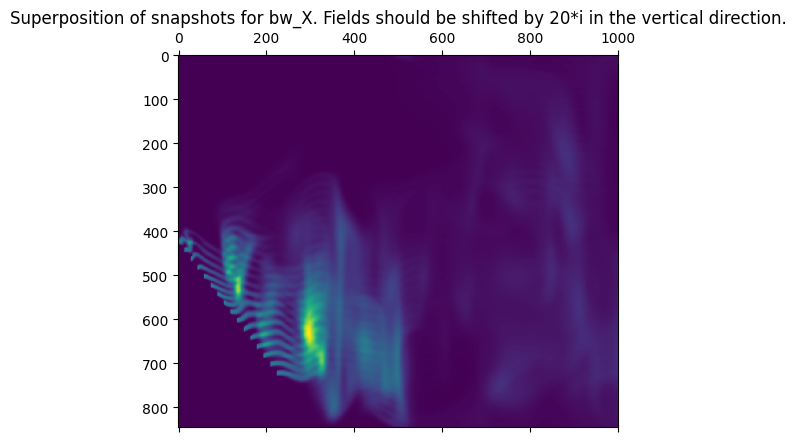

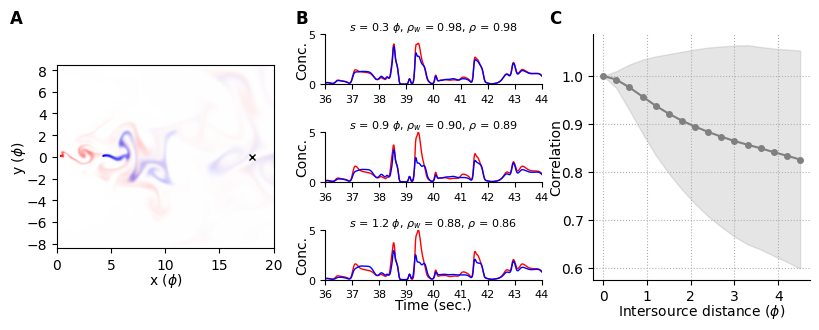

In [100]:
reload(fpf)
reload(fpft)
for k, F in sorted(data.items()):
    if surrQ(k): continue
    fields = F.load_saved_snapshots(t = 40, data_dir = snapshots_dir["bw_X"])
    fk = list(fields.keys())
    X = 0*fields[fk[0]]
    for i, ki in enumerate(fk):
        X += np.roll(fields[ki], 20*i, axis=0)
    matshow(X)
    title(f"Superposition of snapshots for {k}. Fields should be shifted by 20*i in the vertical direction.")   
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, snapshot_time[k], which_srcs[k],
                                                    t_center = (snapshot_time[k].to(UNITS.ms).magnitude//1000)*1000 * UNITS.ms,
                                                    y_lim = (0,5.01) if not surrQ(k) else (-3.01,3.01), y_ticks = [-3,0,3] if surrQ(k) else None,
                                                    data_dir = snapshots_dir[k],
                                                    t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])
    if surrQ(k) or k  in ["bw"]: ax_corr.set_xticks(arange(5))
    if surrQ(k): [ax_corr.set_ylim(-0.85,1.05), ax_corr.set_ylabel("Correlation",labelpad=-8)]
    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir_wnd_shp_len}/plumes_demo_{k}.pdf"
    #ax_corr.set_ylim(-0.5,1.02)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Set the probe index we'll use

In [101]:
iprb = 0

# Figure showing the distribution of correlations

bw_X
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser9/1s/corr_components_bw_X.pdf.


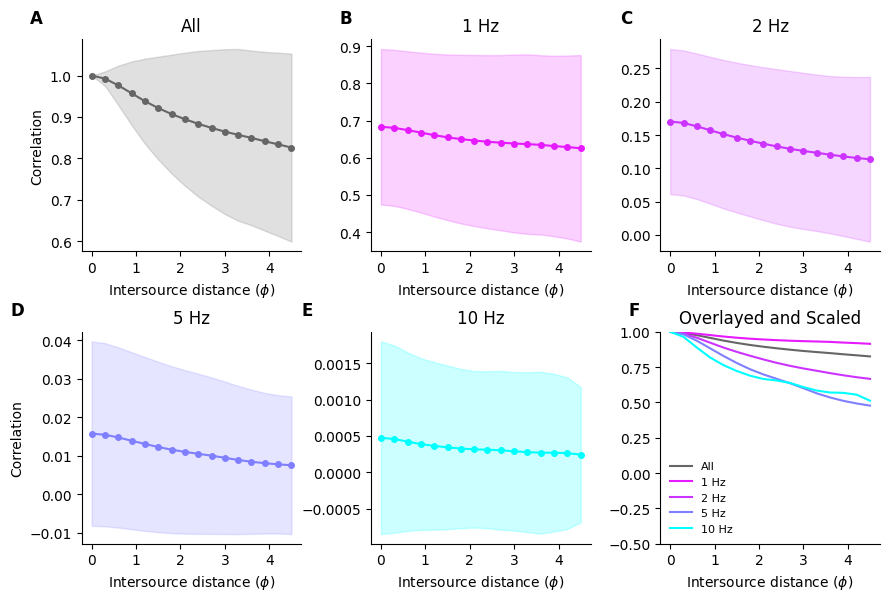

s=p_0
Mapped frequencies [ 1  2  5 10] Hz to indices [1, 2, 5, 10].


Wrote figs/kaiser9/1s/corr_components_s=p_0.pdf.


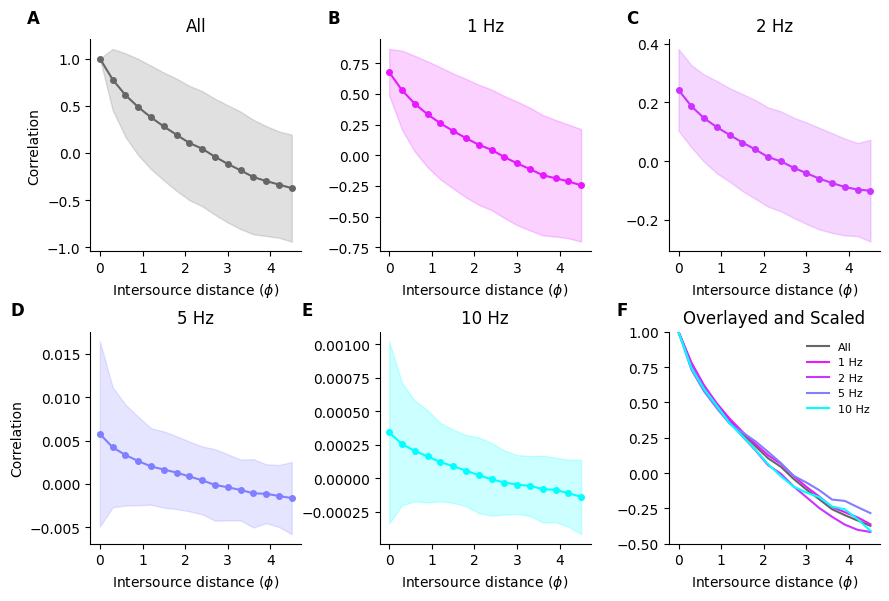

In [102]:
reload(fpf)
xlims_  = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = defaultdict(lambda: DEFAULT) #{"su_high":DEFAULT, "su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    if k.startswith("s=p"):
        if not k == "s=p_0":
            continue
    which_freqs = [1,2,5,10] * UNITS.Hz
    labs = [f"{f}" for f in which_freqs]
    cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})    
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch.to("um").magnitude, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir_wnd_shp_len}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)
    ax[-1].set_ylim(-0.5,1)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."))
    sys.stdout.flush(); plt.show()

# Phase relationships

{'a': (0.45, 0.5625), 'b': (0.55, 0.5625), 'c': (0.45, 0.4375), 'd': (0.55, 0.4375)}


Wrote figs/kaiser9/1s/a_vs_bcd_bw_X_5Hz_idist=1.pdf.


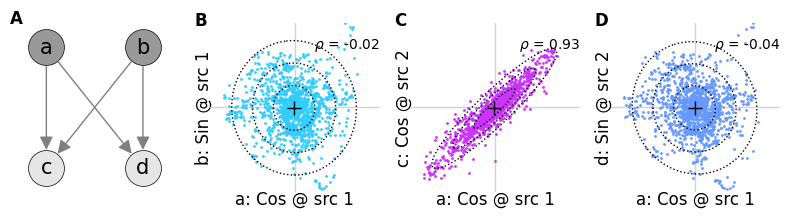

In [103]:
reload(fpf)
which_freq   = 5 * UNITS.Hz
which_idists = defaultdict(lambda: 1, {"bw":1})

for name, F in data.items():
    #if name != "bw" or not "16" in name: continue
    if surrQ(name): continue
    figure(figsize=(8,3))
    ifreq = F.freqs2inds([which_freq])[0]
    idist = which_idists[name]
    axes = [subplot(1,4,i+1) for i in range(4)]
    plt.sca(axes[0])
    fpf.plot_gm(sc=4.5, scale=[0.1,0.125],dxy=[0,0])    
    axes[0].axis("square")
    axes[0].set_ylim([0.41,0.59])
    ax_ = fpf.plot_a_vs_bcd(F, ifreq, idist, cols = [cm.cool(0.2), cm.cool(0.8), cm.cool(0.4)], al=[-0.5,0.5], ax = axes[1:])
    tight_layout()
    fpft.label_axes(axes, "ABCD", fontsize=12, fontweight="bold", dy=-0.01, align_y=[0,1,2,3])            
    file_name = f"{fig_dir_wnd_shp_len}/a_vs_bcd_{name}_{which_freq.magnitude}Hz_{idist=}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()


# The Multivariate Gaussian Fits

bw_X
Mapped 5 Hz to index 5.


Wrote figs/kaiser9/1s/coef_vs_coef_bw_X_5Hz_a_c__a_d.pdf.


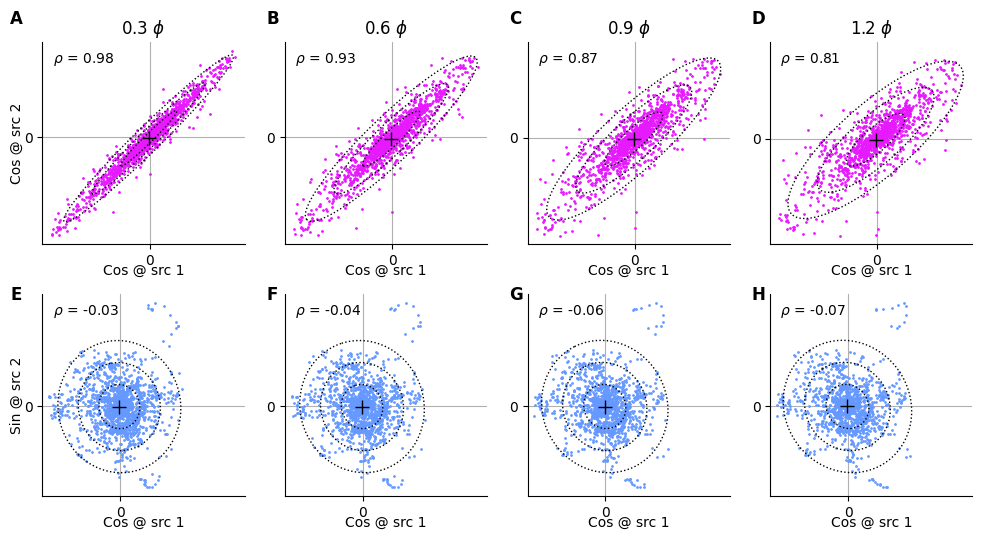

Mapped 10 Hz to index 10.


Wrote figs/kaiser9/1s/coef_vs_coef_bw_X_10Hz_a_c__a_d.pdf.


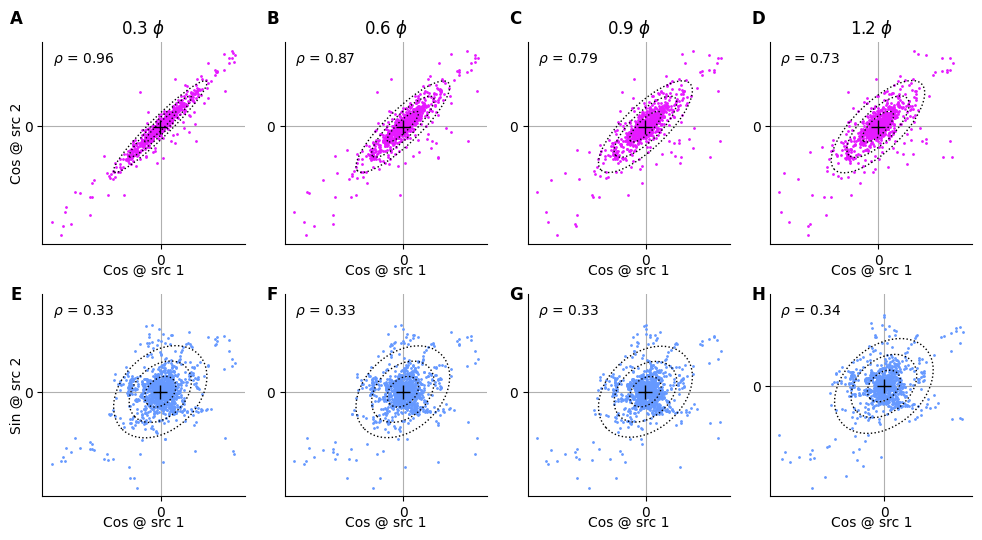

s=p_0
s=p_1
s=p_2
s=p_3


In [104]:
reload(fpf)
freqs_to_plot = [5 * UNITS.Hz, 10 * UNITS.Hz]
which_freqs = dict_update_from_field({"bw":freqs_to_plot,   },   su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw"); 
which_idists= dict_update_from_field({"bw":[0,1,2,3],         },   su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw"); 
dcol_scales = dict_update_from_field({"bw":120000,          },   su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw");
configs = ["a_c", "a_d"]
cols    = [cm.cool(r) for r in [0.9, 0.4]]
for name, F in sorted(data.items()):
    print(name)
    if surr_trialsQ(name): continue
    #if name!="bw": continue
    for which_freq in which_freqs[name]:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        
        figure(figsize=(12, 3 * len(configs)))
        axes = []
        for i, config in enumerate(configs):
            idists = which_idists[name]
            ax = [subplot(len(configs), len(idists), i*len(idists) + j+1) for j in range(len(idists))]
            ax_ = fpf.plot_coef1_vs_coef2(F,
                                          ifreq,
                                          config=config,
                                          iprb=iprb,
                                          i_pos_dists_to_plot = which_idists[name],
                                          col = cols[i],
                                          axes = ax,
                                          do_corr = True,
            )
            if i:
                [axi.set_title("") for axi in ax_]
                        
            axes.extend(ax)
        fpft.label_axes(axes, "ABCDEFGH", fontsize=12, fontweight="bold", dy=-0.01)            
        file_name = f"{fig_dir_wnd_shp_len}/coef_vs_coef_{name}_{which_freq.magnitude}Hz_{'__'.join(configs)}.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Supplementary Information

# Plot scattergrams

bw_X
Mapped 2 Hz to index 2.


Wrote figs/kaiser9/1s/scattergram_bw_X_2Hz.pdf.


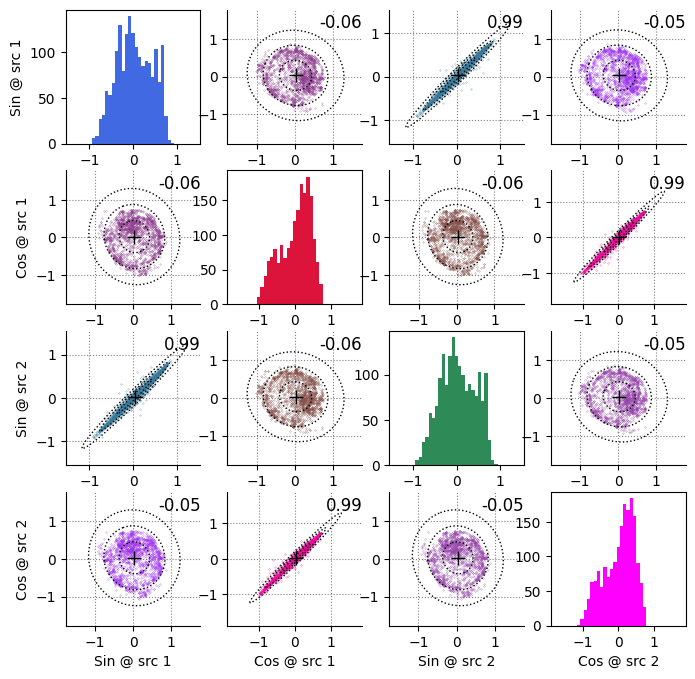

Mapped 5 Hz to index 5.


Wrote figs/kaiser9/1s/scattergram_bw_X_5Hz.pdf.


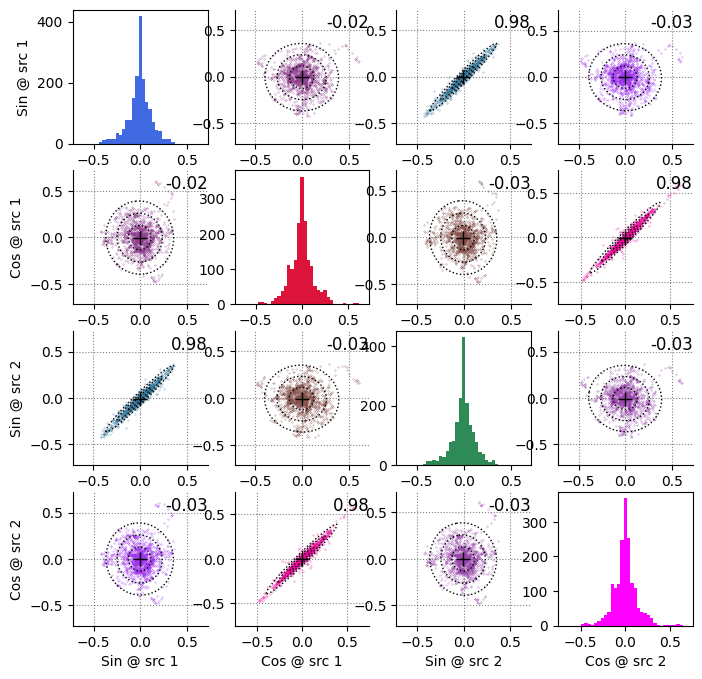

Mapped 8 Hz to index 8.


Wrote figs/kaiser9/1s/scattergram_bw_X_8Hz.pdf.


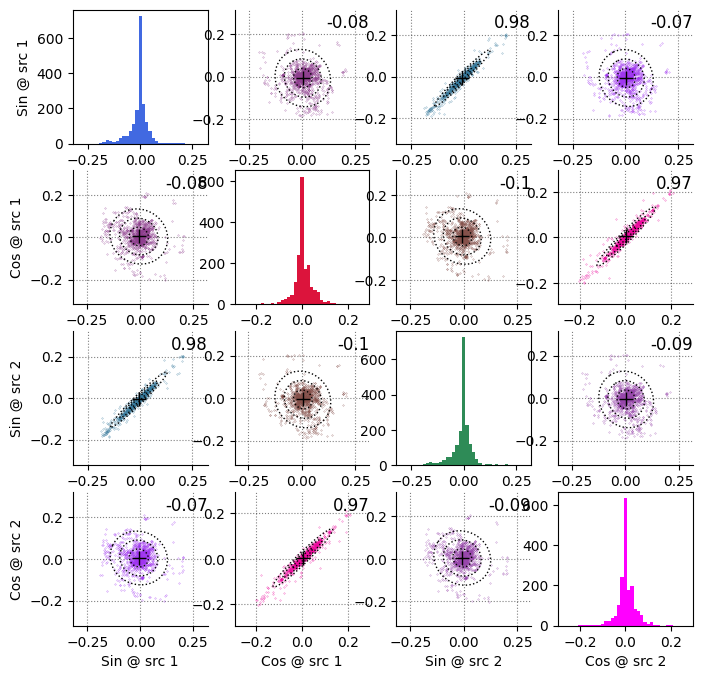

Mapped 10 Hz to index 10.


Wrote figs/kaiser9/1s/scattergram_bw_X_10Hz.pdf.


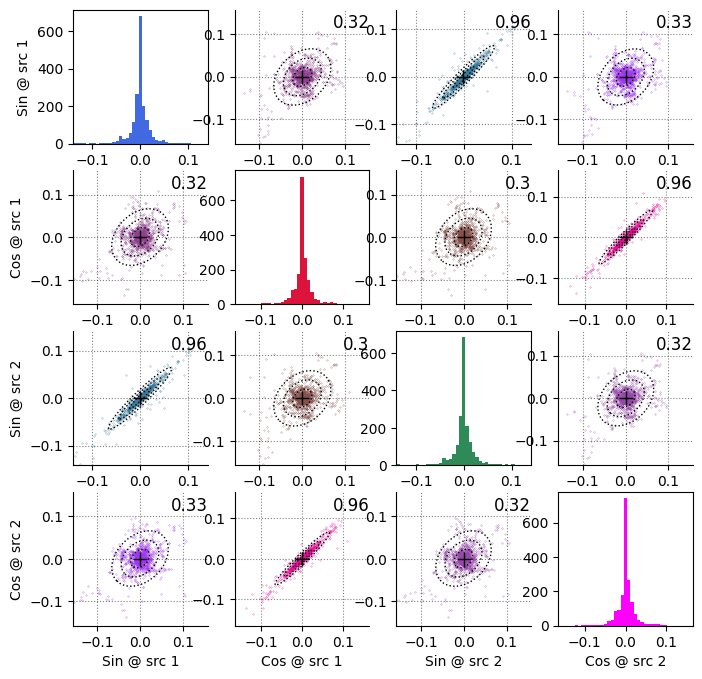

s=p_0
s=p_1
s=p_2
s=p_3


In [105]:
reload(fpft)
reload(fpf)
freqs_to_plot = [2 * UNITS.Hz, 5 * UNITS.Hz, 8 * UNITS.Hz, 10 * UNITS.Hz]
#freqs_to_plot = [1 * UNITS.Hz]#, 5 * UNITS.Hz, 8 * UNITS.Hz, 10 * UNITS.Hz]
which_freqs = dict_update_from_field({"bw":freqs_to_plot,   "cr":freqs_to_plot},   su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw"); 
for name, F in sorted(data.items()):
    print(name)
    if surr_trialsQ(name): continue
    for which_freq in which_freqs[name]:
        ifreq = F.freqs2inds([which_freq])[0]
        print(f"Mapped {which_freq} to index {ifreq}.")
        ax = fpf.plot_scattergram(F,
                                  ifreq,
                                  iprb,
                                  figsize=(8,8),
                                  dist_col_scale = dcol_scales[name],
                                  markersize = 0.2,
                                  cols = ["royalblue","crimson", "seagreen", "magenta"],
                                  coef_names = {0:"Sin", 1:"Cos"},
                                  lim_scale = 2.,
                                  print_fun = np.corrcoef,
                                  )
        file_name = f"{fig_dir_wnd_shp_len}/scattergram_{name}_{which_freq.magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Relative contribution of in-phase-component

Wrote figs/kaiser9/1s/phase_heatmap_bw_X.pdf.


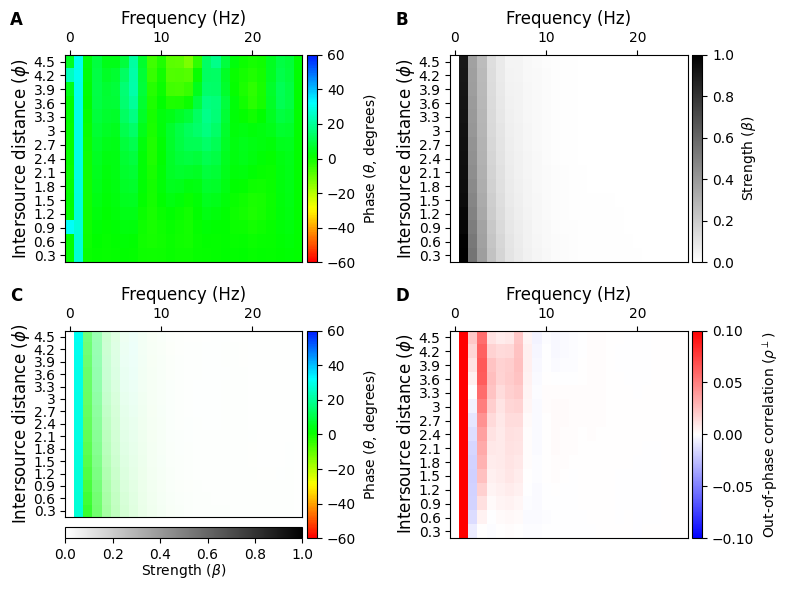

In [106]:
reload(fpf)
for name, F in sorted(data.items()):
    if surr_trialsQ(name): continue
    ax = fpf.plot_phase_heatmap(F, max_phi = pi/3, plot_which="all", max_corr=0.1,figsize=(8,6))
    plt.tight_layout()
    fpft.label_axes(ax, "ABCD", 
                    align_y = [[0,1],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.025)
    file_name = f"{fig_dir_wnd_shp_len}/phase_heatmap_{name}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Asymmetric Laplacian Fits

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:525: RuntimeWarning: divide by zero encountered in log10
  rr    = F.rho[which_probe][d][0][which_ifreq]
      fisher_plumes_figs 2024/04/04 17:21:29     INFO: d=  0 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2024/04/04 17:21:29     INFO: d=8000 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2024/04/04 17:21:29     INFO: d=16000 @ Freq #   5: -np.log10(p) = inf


16Ts
[-0.02, 0.05]


val shape:  (51, 2)
(51, 16)
Setting extent to [-0.5, 15.5, 0.5, 20.5].
val shape:  (50, 2)
(50, 16)
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
<ipython-input-44-02e9dd46aa6b>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout(pad=0)


Wrote figs/kaiser9/1s/alap_fits_16Ts_5Hz.pdf.


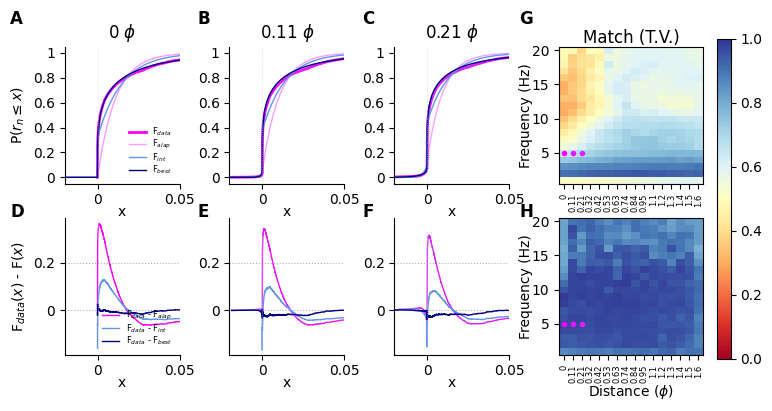

/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:525: RuntimeWarning: divide by zero encountered in log10
  rr    = F.rho[which_probe][d][0][which_ifreq]
      fisher_plumes_figs 2024/04/04 17:21:34     INFO: d=  0 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2024/04/04 17:21:34     INFO: d=8000 @ Freq #   5: -np.log10(p) = inf


      fisher_plumes_figs 2024/04/04 17:21:34     INFO: d=16000 @ Freq #   5: -np.log10(p) = inf


16Ts_X
[-0.02, 0.05]
val shape:  (51, 2)
(51, 32)
Setting extent to [-0.5, 31.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


<ipython-input-44-02e9dd46aa6b>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout(pad=0)


val shape:  (50, 2)
(50, 16)
Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/kaiser9/1s/alap_fits_16Ts_X_5Hz.pdf.


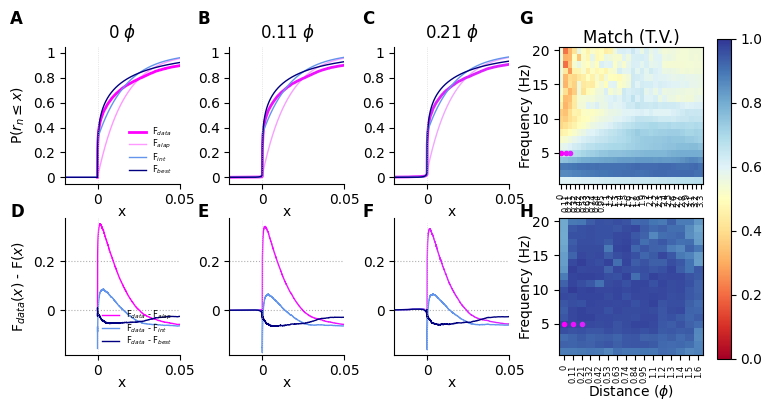

In [44]:
reload(fpft)
reload(fpf)
idist     = dict_update_from_field({"bw":[0,1,2],          "cr":[1,13,15]},         su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"],"cr")
freq_max  = dict_update_from_field({"bw":21 * UNITS.hertz, "cr":101 * UNITS.hertz}, su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"],"cr")
vmin      = dict_update_from_field({"bw":[0,0],          "cr":[0,0]},           su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"],"cr")
vmax      = dict_update_from_field({"bw":[1,1],           "cr":[1,1]},            su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"],"cr")
for name, F in sorted(data.items()):
    if surrQ(name): continue
    if surr_trialsQ(name): continue
    #if name != "bw": continue
    print(name)
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f, xl in zip([1,5,10] * UNITS.hertz, [[-0.25, 1.0], [-0.02, 0.05], [-0.02, 0.05]]):
        if f != 5 * UNITS.hertz: continue
        which_freq = defaultdict(lambda: f)
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                                                        ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                                                        which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(9,4),
                                                        fit_color="gray",
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        expansion = 1.0,
                                                        xl = xl,
                                                        fit_corrs = "search.1",
                                                        leg_loc = None,
                                                        leg_loc2 = "lower right",
                                                        cdf_mode = "even")
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]],
                        align_x = [[0,3],[1,4],[2,5],[6,7]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_wnd_shp_len}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
        sys.stdout.flush(); plt.show()

# Plot the figure showing ρ(s)

      fisher_plumes_figs 2024/05/02 21:15:19     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 3, 7, 10], log_scale=True.


Wrote figs/kaiser9/1s/fit_k=False/fit_b=True/rho_vs_s_fits_bw_X.pdf.


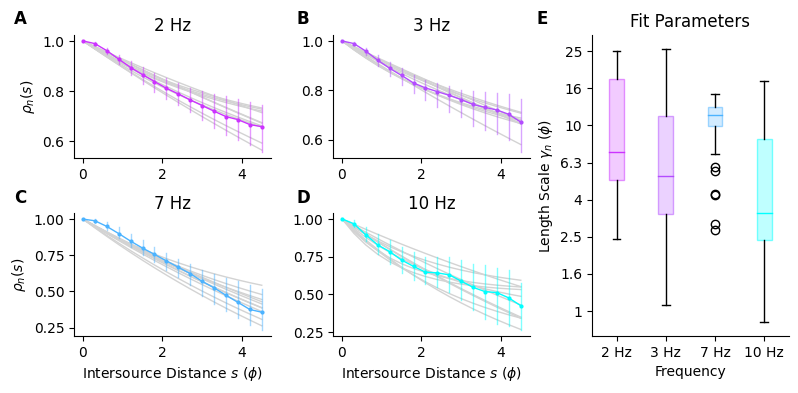

In [107]:
reload(fpft)
reload(fpf)
freqs  = dict_update({fld:[2,3,7,10] * UNITS.hertz for fld in ["bw", "cr", "su", "16T", "16Ts", "16Ts_X", "16Ts_45", "bw_X"]}, ["su_high_white", "su_high_pink", "su_high2_pink", "su_white"], [[1,3,17,20] * UNITS.hertz]*4)
xl     = dict_update_from_field({"bw":(-10,200),                 "cr": (-2, 50)},                    su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"], "cr"); xl["bw_X"] = xl["bw"]
xt     = dict_update_from_field({"bw":arange(0,201,50),          "cr": arange(0,101,25)},            su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"], "cr"); xt["bw_X"] = xt["bw"]
xtp    = dict_update_from_field({"bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])},  su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"], "cr"); xtp["bw_X"] = xtp["bw"]
ytp    = dict_update_from_field({"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}, su_ds + ["16Ts", "16Ts_X", "16Ts_45"], "bw", ["16T"], "cr"); ytp["bw_X"] = ytp["bw"]

#print(f"{wnd_key=:}")
#data_wnd = {k:v[wnd_key] for k,v in proc.items() if wnd_key in v and k != "su_high_pink"}
for k, F in sorted(data.items()):
    if surrQ(k): continue
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          max_bs = 10,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir_full}/rho_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()

# Plot the Fisher Information

      fisher_plumes_figs 2024/05/02 21:15:23     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2024/05/02 21:15:23     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


bw_X


Wrote figs/kaiser9/1s/fit_k=False/fit_b=True/fisher_info_bw_X.pdf.


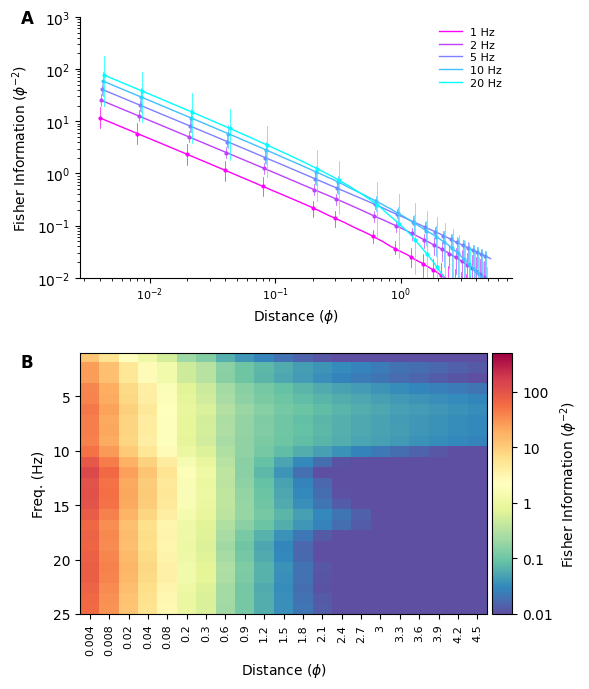

s=p_0
s=p_1
s=p_2
s=p_3


In [108]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs     = dict_update_from_field({"cr":[5,10,20,50,100] * UNITS.hertz, "bw":[1,2, 5, 10, 20] * UNITS.hertz}, su_ds + ["16Ts","16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
freq_max  = dict_update_from_field({"bw":25 * UNITS.hertz, "cr":100 * UNITS.hertz}, su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
colscale  = dict_update_from_field({"bw":10,               "cr":40},                su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
d_vals_um = dict_update_from_field({"bw":[1,5,50],         "cr":[0.1,10,70]},       su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
d_lim_um  = dict_update_from_field({"bw":[100, 125000 ],   "cr":[100, 125000]},     su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
bf_ytick  = dict_update_from_field({"bw":[0,5,10],         "cr":[0,50,100]},        su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
bf_yl     = dict_update_from_field({"bw":[0,15],           "cr":[-5,100]},          su_ds + ["16Ts", "16Ts_X", "16Ts_45", "bw_X"], "bw", ["16T"], "cr")
plot_param_fits = False
for k, F in sorted(data.items()):
    print(k)
    if k not in ["bw","16Ts", "16Ts_X", "16Ts_45", "bw_X"]: continue
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                plot_param_fits = plot_param_fits,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                info_heatmap = True,
                                                                heatmap_range =[-2, log10(500)],
                                                                heatmap_cm    =cm.Spectral_r,
                                                                #bf_ytick  = bf_ytick[k],
    )
    ax_fisher.set_ylim(1e-2,1e3)
    tight_layout(h_pad=2,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1,2] if plot_param_fits else [0,1]],
                    fontsize=12, fontweight="bold", dy=-0.02)
    #ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir_full}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    

# Plot Fisher information heatmaps together

In [109]:
order = ["bw", "s=p_0", "shp", "bw"]
which_wnd = [(1 * UNITS.s, 'hann')] * 3 + [(1 * UNITS.s, 'boxcar')]
data_wnd = [FisherPlumes(proc.load_data(init_filter=to_use[o],
                                          compute_filter = {"window_length":wnd[0],
                                                            "window_shape":wnd[1],
                                                            "fit_k":fit_k, "fit_b":True})[0], load_sims=False) for o,wnd in zip(order,which_wnd)]

KeyError: 'bw'

In [22]:
# Compare our heatmap (A) to surrogate data where
# (B) All frequencies are equally informative
# (C) High freqs arr equally informative
# (D) Our data but with a boxcar window
figure(figsize=(8,5))
gs = GridSpec(2,2)
axes, cbs = [], []
for (o, gsi, datai) in zip(order, gs, data_wnd):
    axes.append(subplot(gsi))
    axes[-1], cbi = fpf.plot_fisher_information_heatmap(datai, 0, ax = axes[-1], freq_max = 25 * UNITS.Hz,
                                                        heatmap_range =[-2, log10(500)],
                                                        heatmap_cm    =cm.Spectral_r,
                                                        do_colorbar   = gsi.is_last_col(),
    )
    if gsi.is_first_row():
        axes[-1].tick_params(labelbottom=False)
        axes[-1].set_xlabel("")

    if not gsi.is_first_col():
        axes[-1].tick_params(labelleft = False)
        axes[-1].set_ylabel("")
tight_layout(w_pad = 1.5, h_pad=1.5)
fpft.label_axes(axes, "ABCD",
                align_y = [[0,1],[2,3]],
                align_x = [[0,2],[1,3]],
                fontsize=12, fontweight="bold", dy=0.01, dx = -0.01)
file_name = f"{fig_dir_fitkb}/fisher_info_heatmaps.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight', pad_inches=0), flush(f"Wrote {file_name}."));
sys.stdout.flush(); plt.show()
        

NameError: name 'data_wnd' is not defined

<Figure size 800x500 with 0 Axes>

NameError: name 'data_wnd' is not defined

# Length constants vs frequency

Wrote figs/kaiser9/1s/fit_k=False/fit_b=True/length_vs_freq_bw_X.pdf.


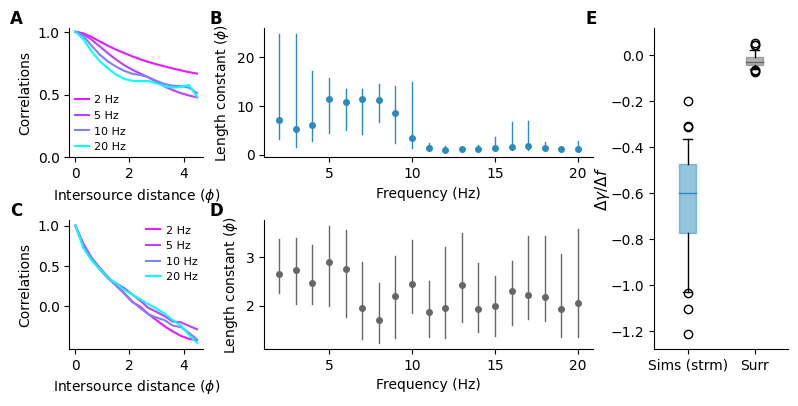

In [111]:
reload(fpf)
for ds in ["16Ts", "16Ts_X", "16Ts_45", "bw_X"]:
    if ds not in data: continue
    which_ds = [ds,"s=p_0"]
    ax, ax_γ = fpf.plot_length_constants_vs_frequency(data, which_ds, iprb)
    fpft.label_axes(ax + [ax_γ], "ABCDE",
                    fontsize=12, fontweight="bold",
                    dx = -0.01, dy=0.01,
                    align_x = [[0,2],[1,3]],
                    align_y = [[0,1,4]])
    
    file_name = f"{fig_dir_full}/length_vs_freq_{which_ds[0]}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()
    


# Regressing information on frequency

(10, 5.0)
ils_origin=<Quantity(0.865727808, 'boulder16streamwise_pitch')>
ils_probe=<Quantity(2.26635976, 'boulder16streamwise_pitch')>


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:1320: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_coef.set_yticklabels([f"{yti:g}" for yti in ax_coef.get_yticks()], fontsize=10)


Wrote figs/kaiser9/1s/fit_k=False/fit_b=True/reg_coefs_bw_X.pdf.


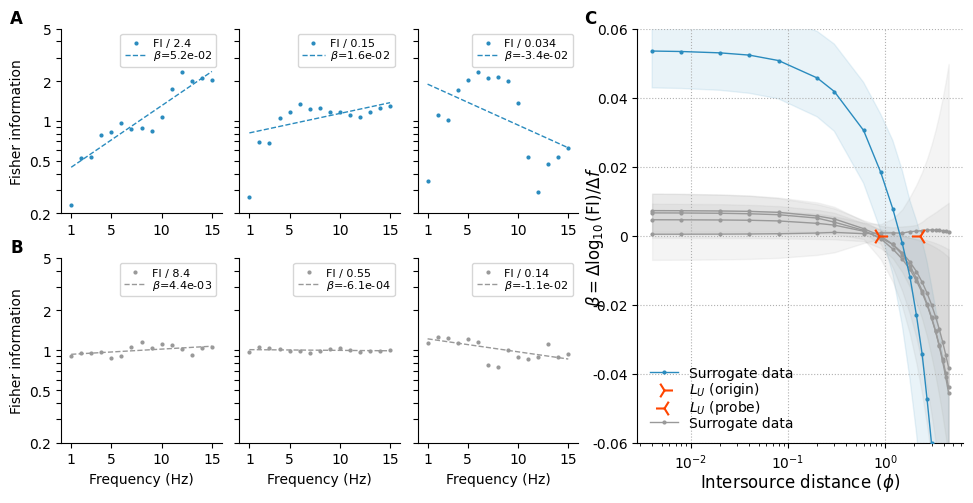

In [113]:
reload(fpf)
for ds in ["bw_X"]:#["16Ts_X"]:
    #if ds != "bw": continue
    #which_ds = [ds,"s=p"]
    #ax, ax_coef = fpf.plot_information_regression(data, which_ds, iprb, plot_ils = True)    

    which_ds = [f"s=p_{i}" for i in range(4)]
    ind_detail = []
    # Order which_ds with the ones we want to highlight first, indicated in ind_detail, then the rest.
    which_ds = [which_ds[i] for i in ind_detail] + [which_ds[i] for i in range(len(which_ds)) if i not in ind_detail]
    names = {ki:ki for ki in which_ds}
    names["bw"] = "boulder"
    # cols = {k:cm.hsv(i/(len(which_ds))) for i,k in enumerate(which_ds)}
    ax, ax_coef = fpf.plot_information_regression(data, [ds] + which_ds, iprb, plot_ils = True, do_label = [True]*2 + [False]*(len(which_ds)-1), yl=(-0.06,0.06))
    

    fpft.label_axes([ax[0][0], ax[1][0], ax_coef], "ABC",
                    fontsize=12, fontweight="bold",
                    align_x = [[0,1]],
                    align_y = [[0,2]])
    
    file_name = f"{fig_dir_full}/reg_coefs_{ds}.pdf"
    #tight_layout(pad=0,w_pad=0, h_pad=0)
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    sys.stdout.flush(); plt.show()


# Velocity autocorrelation functions

Wrote figs/ils_supp.pdf.


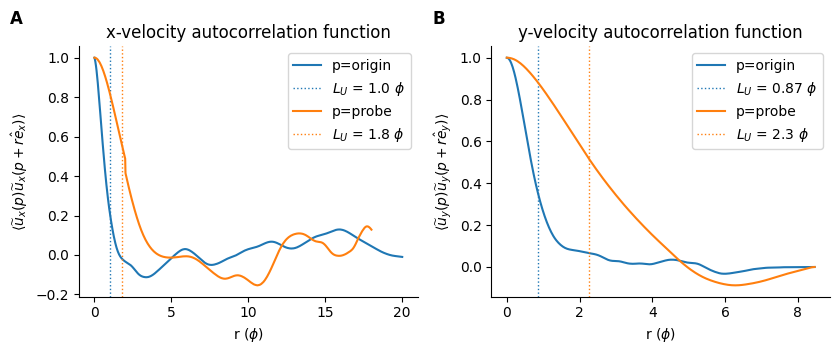

In [118]:
kk = "bw_X"
ils = data[kk].sim0.integral_length_scales
keys = ils.keys()
figure(figsize=(8.5,3.5))
ax = []
for i, d in enumerate("xy"):
    ax.append(subplot(1,2,i+1))
    orig_key = (0 * UNITS.m, 0 * UNITS.m, d)
    probe_key = [k for k in keys if k[-1]==d and k!=orig_key][0]
    for j, (k, name) in enumerate(zip([orig_key,probe_key], ["origin", "probe"])):
        res   = ils[k]
        fr, l = res["fr"], res["l"]
        # l = nansum(fr) * ds
        ds = l / nansum(fr)
        xx = arange(len(fr))*ds.to(data[kk].pitch).magnitude
        plot(xx, fr, label=f"p={name}")
        lmag = l.to(data[kk].pitch).magnitude
        gca().axvline(lmag, color=f"C{j}", linewidth=1, linestyle=":", label = f"$L_U$ = {lmag:.2} {fpf.pitch_sym}")
    legend()
    ylabel(f"$\langle \\widetilde u_{d}(p) \\widetilde u_{d}(p + r \hat e_{d}) \\rangle$")
    xlabel(f"r ({fpf.pitch_sym})")
    title(f"{d}-velocity autocorrelation function")
    fpft.spines_off(gca())
tight_layout()
fpft.label_axes(ax, "AB",
                    fontsize=12, fontweight="bold",
                    align_y = [[0,1]])
file_name = f"figs/ils_supp.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));
    

# Compute the spectrum

In [119]:
Info = namedtuple('Info','name,color')
infos = {"16Ts": Info(name="Supp. dataset",               color = "dodgerblue"),
         "16Ts_X": Info(name="Supp. dataset (X)",               color = "dodgerblue"),
         "16Ts_45": Info(name="Supp. dataset (45 deg)",               color = "dodgerblue"),
         "bw":   Info(name="Main dataset",                color = "orangered"),
         "bw_X":   Info(name="Main dataset (streamwise)",                color = "orange"),
         "s=p_0":  Info(name="Surrogate (all =)",     color = "pink"),
         "s=w":  Info(name="Surrogate (all =, white)",    color = "green"),
         "shw":  Info(name="Surrogate (high>low, white)", color = "silver"),
         "shp":  Info(name="Surrogate (high>low)",  color = "violet"),
         "s=w_q0":  Info(name="Surrogate (quad, ϕ=0, white)", color="blue"),
         "s=w_q1":  Info(name="Surrogate (quad, ϕ=π/3, white)", color="green"),
}

Wrote figs/boxcar/1s/spectra.pdf.


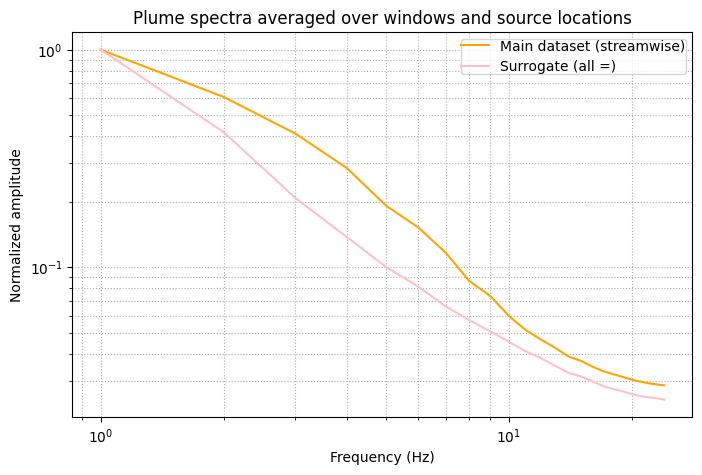

In [120]:
figure(figsize=(8,5))
for ki, k in enumerate(sorted(data, key=lambda x: infos[x].name if x in infos else x)):
    if k not in infos: continue
    f = []
    for _, s in data[k].stft.items():
        fr, tt, S = s[0]
        f.append(np.abs(S))
        
    fs = F.fs.to("Hz").magnitude
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1] * (10**0),
           label=infos[k].name,
           color=infos[k].color)
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both', linestyle=":")
fig_dir = fpft.get_fig_dir(window_shape="boxcar", window_length=1*UNITS.s, create=True)
file_name = f"{fig_dir}/spectra.pdf"
SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), flush(f"Wrote {file_name}."));

# The End

# Sandbox

I'm not sure I buy the results:
1. I was expecting that the out-of-phase information would be more important when both sources are on the midline, but that doesn't seem to be the case.
2. It seems like I only get the elbow plot when I use enough sources - when I use just the initial set of sources, it seems that high frequencies are always more informative.

In [12]:
data.keys()

dict_keys(['16Ts', '16Ts_X', 's=p_0', 's=p_1', 's=p_2', 's=p_3'])

Using pair 6 for idist 0, dist 8000
ia = 248000, ib = 240000
Using pair 12 for idist 1, dist 16000
ia = 248000, ib = 232000


Using pair 20 for idist 2, dist 24000
ia = 248000, ib = 224000


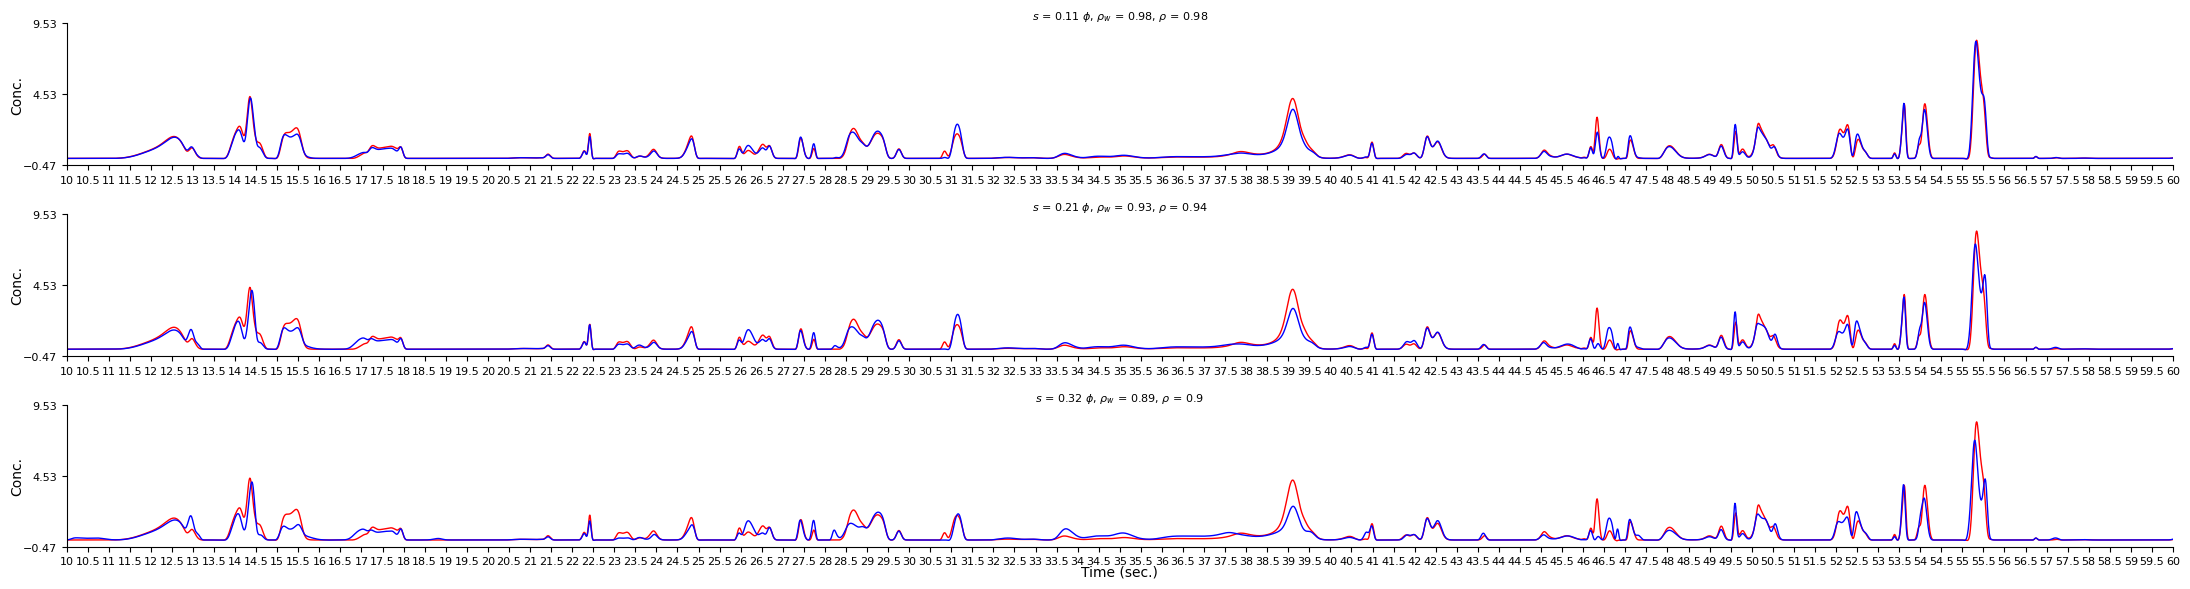

In [37]:
figure(figsize=(22,6))
reload(fpf)
fpf.plot_two_plumes(data["16Ts_X"], [0,1,2],[10*UNITS.sec,60*UNITS.sec], which_probe = 0, dt = 0.5 * UNITS.sec, y_lim = None, y_ticks = None, axes = None, pos_dists = True, centered=True, cols=["r","b"])
tight_layout()

Using pair 12 for idist 0, dist 8000
ia = 560000, ib = 552000
Using pair 3 for idist 1, dist 16000
ia = 560000, ib = 544000


Using pair 4 for idist 2, dist 24000
ia = 560000, ib = 536000


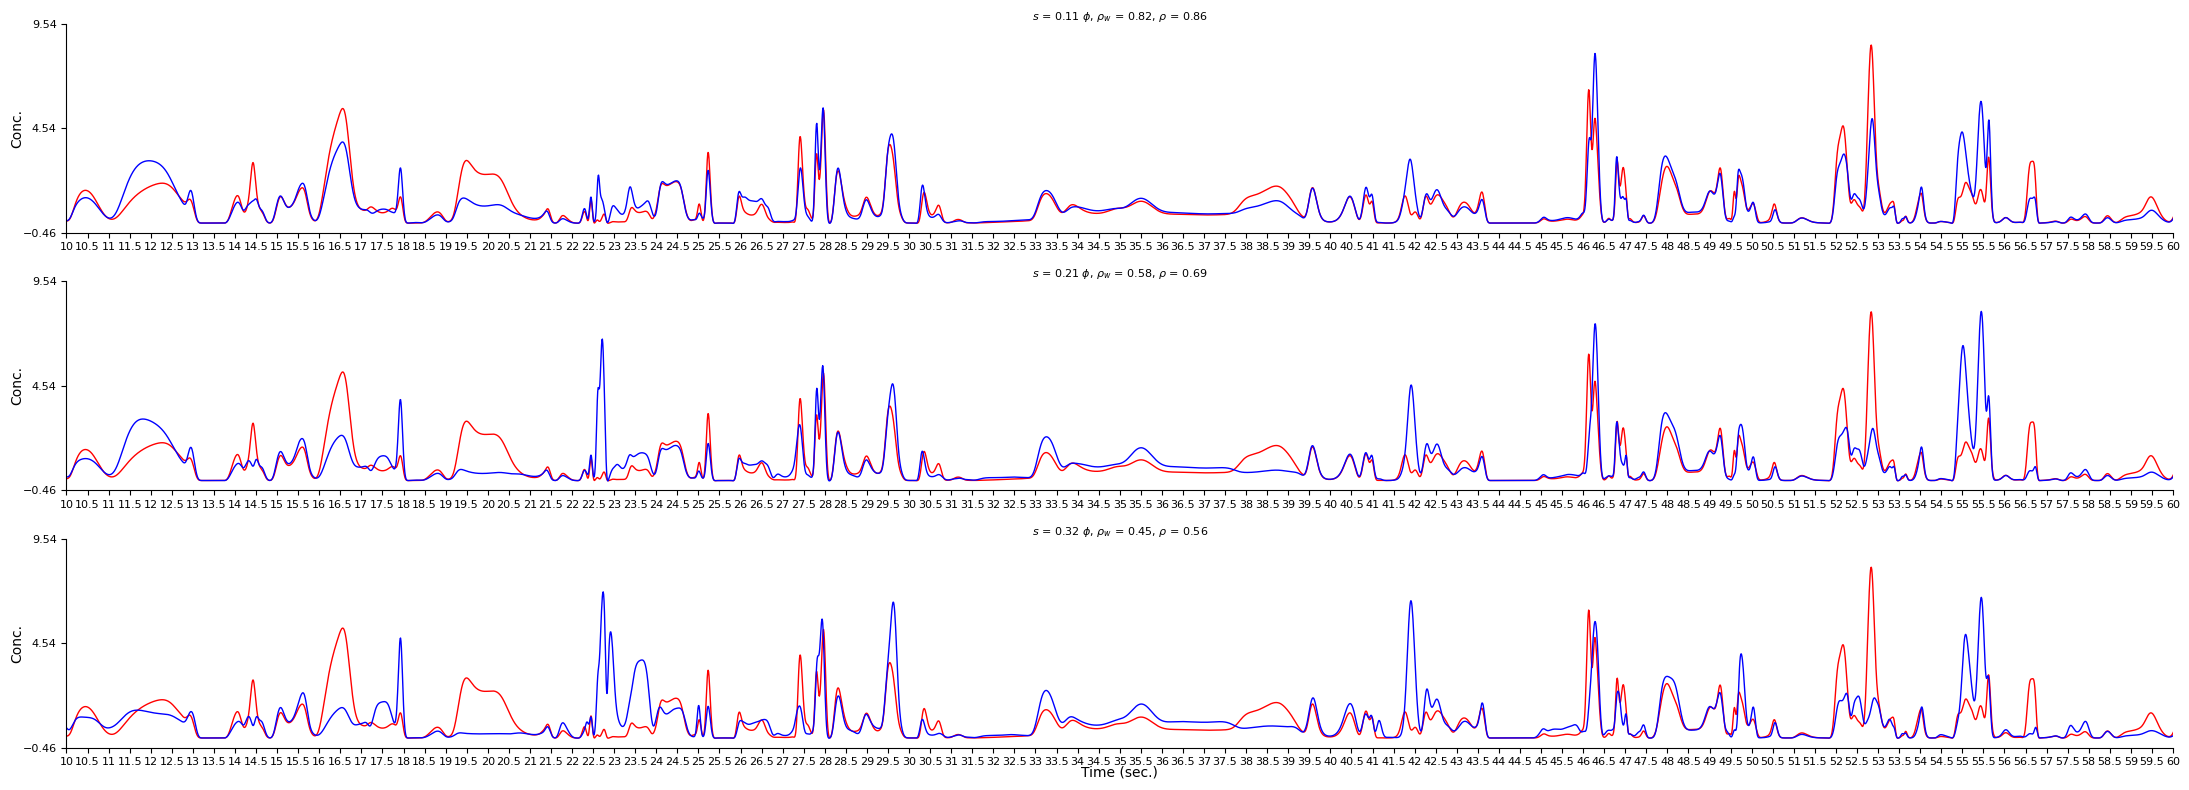

In [38]:
figure(figsize=(22,8))
fpf.plot_two_plumes(data["16Ts"], [0,1,2],[10*UNITS.sec,60*UNITS.sec], which_probe = 0, dt = 0.5 * UNITS.sec, y_lim = None, y_ticks = None, axes = None, pos_dists = True, centered=True, cols=["r","b"])
tight_layout()